Project Title and Brief

In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [2]:
url ="http://publicplansdata.org/api/"
#focus_years=["2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019"]

Import API Data

In [3]:
#Import API Data
paramsratios = {
    "q": "QDataset",
    "dataset": "pensiongasbschedules",
     "format": "json",
    #"variables": 
     #"v": variables,
}
paramsbasicplandata = {
    "q": "QDataset",
    "dataset": "pensionplanbasics",
     "format": "json",
    #"variables": 
     #"v": ,
}
paramsbasicinvestperform = {
    "q": "QDataset",
    "dataset": "pensioninvestmentperformancedetailed_actl",
     "format": "json",
    #"variables": 
     #"v": ,
}
paramsinvestreturn = {
    "q": "QDataset",
    "dataset": "pensioninvestmentreturn",
     "format": "json",
    #"variables": 
     #"v": ,
}
paramsreturnassumptions = {
    "q": "QDataset",
    "dataset": "pensiongasbassumptions",
     "format": "json",
    #"variables": 
     #"v": ,
}
paramspenincomestatement = {
    "q": "QDataset",
    "dataset": "pensionincomestatement",
     "format": "json",
    #"variables": 
     #"v": ,
}
paramspenactliab = {
    "q": "QDataset",
    "dataset": "pensionactuarialliabilities",
     "format": "json",
    #"variables": 
     #"v": ,
}

In [4]:
#create requests
ratiosresponse = requests.get(url, params = paramsratios)
plandataresponse = requests.get(url,params=paramsbasicplandata)
investperformresponse = requests.get(url,params=paramsbasicinvestperform)
investreturnresponse = requests.get(url,params=paramsinvestreturn)
returnassumptionsresponse = requests.get(url,params=paramsreturnassumptions)
penincomestatementresponse = requests.get(url,params=paramspenincomestatement)
penactliabresponse = requests.get(url,params=paramspenactliab)

In [5]:
#create json response object
fundedratiosdata = ratiosresponse.json()
plandata = plandataresponse.json()
investperform = investperformresponse.json()
investreturn = investreturnresponse.json()
returnassumptions = returnassumptionsresponse.json()
penincomestatement=penincomestatementresponse.json()
penactliab = penactliabresponse.json()

In [6]:
#change response objects into DataFrames
funded_ratios_full = pd.DataFrame(fundedratiosdata[1:])
plan_data_full = pd.DataFrame(plandata[1:])
investperform_data_full=pd.DataFrame(investperform[1:])
investreturn_data_full=pd.DataFrame(investreturn[1:])
returnassumptions_data_full=pd.DataFrame(returnassumptions[1:])
penincomestatement_data_full=pd.DataFrame(penincomestatement[1:])
penactliab_data_full=pd.DataFrame(penactliab[1:])

Find Steady Group ppd_IDs. "Steady" plans are defined as those that had a funded ratio of 90% or higher for every year from 2001 to 2019.

In [7]:
#generate subset DFs and remove rows with empty funded ratio data
funded_ratio_df=funded_ratios_full[['ppd_id','fy','ActFundedRatio_GASB','ActFundedRatio_est','PercentReqContPaid']].dropna()
plan_data_df=plan_data_full[['ppd_id','PlanName','StateAbbrev','PlanClosed','PlanYearClosed',]]

In [8]:
#merge tables to create data set with plan data and funded ratio data by year
plan_test_data_df=pd.merge(funded_ratio_df,plan_data_df,how="inner",on="ppd_id")
plan_test_data_df['ActFundedRatio_GASB'] = plan_test_data_df['ActFundedRatio_GASB'].astype(float)
plan_test_data_df['PercentReqContPaid'] = plan_test_data_df['PercentReqContPaid'].astype(float)

In [9]:
#Find all rows that have a funded ratio greater than or equal to 90%
plan_data_90plus=plan_test_data_df[(plan_test_data_df['ActFundedRatio_GASB']>=.90)]

In [10]:
#Find plans that have at least 19 rows (fiscal years) that were above 90% funded
plan_90plus_counts=plan_data_90plus.groupby("ppd_id")["fy"].count()
plan_90plus_19plus=plan_90plus_counts[plan_90plus_counts>=19]
steady_plan_candidates=plan_90plus_19plus.index.values
steady_plan_candidates

array(['101', '110', '117', '122', '125', '178', '179', '83'],
      dtype=object)

In [11]:
#Confirm that each plan has data for all years 2001-2019
for plans in steady_plan_candidates:
    plan_data_check=plan_data_90plus[(plan_data_90plus["ppd_id"]==plans)]
    print(plans)
    print(plan_data_check["fy"])

101
1970    2001
1971    2002
1972    2003
1973    2004
1974    2005
1975    2006
1976    2007
1977    2008
1978    2009
1979    2010
1980    2011
1981    2012
1982    2013
1983    2014
1984    2015
1985    2016
1986    2017
1987    2018
1988    2019
1989    2020
Name: fy, dtype: object
110
2140    2001
2141    2002
2142    2003
2143    2004
2144    2005
2145    2006
2146    2007
2147    2008
2148    2009
2149    2010
2150    2011
2151    2012
2152    2013
2153    2014
2154    2015
2155    2016
2156    2017
2157    2018
2158    2019
Name: fy, dtype: object
117
2258    2001
2259    2002
2260    2003
2261    2004
2262    2005
2263    2006
2264    2007
2265    2008
2266    2009
2267    2010
2268    2011
2269    2012
2270    2013
2271    2014
2272    2015
2273    2016
2274    2017
2275    2018
2276    2019
2277    2020
Name: fy, dtype: object
122
2318    2001
2319    2002
2320    2003
2321    2004
2322    2005
2323    2006
2324    2007
2325    2008
2326    2009
2327    2010
2328    2011
23

In [12]:
steady_group_list=['101', '110', '125', '179']

Find Most Improved Group ppd_IDs.  "Most Improved" plans are defined as those that showed the highest difference between their funded ratio in 2001 and their funded ratio in 2019.

In [13]:
#Generate subset DFs and merge to create single fy row with 2001 and 2019 funded ratio data for each plan
plan_data_2019=plan_test_data_df[(plan_test_data_df['fy']=='2019')]
plan_data_2019=plan_data_2019[['ppd_id','fy','ActFundedRatio_GASB','PlanName']]
plan_data_2001=plan_test_data_df[(plan_test_data_df['fy']=='2001')]
plan_data_2001=plan_data_2001[['ppd_id','fy','ActFundedRatio_GASB']]
improved_plan_df = plan_data_2019.merge(plan_data_2001, how='inner', on='ppd_id', suffixes=('_2019','_2001'))
improved_plan_df['ActFundedRatio_GASB_2001']=improved_plan_df['ActFundedRatio_GASB_2001'].astype(float)
improved_plan_df['ActFundedRatio_GASB_2019']=improved_plan_df['ActFundedRatio_GASB_2019'].astype(float)

In [14]:
#Calculate delta between 2019 funded ratio and 2001 funded ratio
improved_plan_df['delta_plan'] = improved_plan_df['ActFundedRatio_GASB_2019'] - improved_plan_df['ActFundedRatio_GASB_2001']

#Most improved are plans with the highest delta
most_improved = improved_plan_df.sort_values(by='delta_plan', ascending=False)
most_improved[['ppd_id','PlanName','delta_plan','fy_2019','ActFundedRatio_GASB_2019','fy_2001','ActFundedRatio_GASB_2001']].head(5)

,ppd_id,PlanName,delta_plan,fy_2019,ActFundedRatio_GASB_2019,fy_2001,ActFundedRatio_GASB_2001
100,124,West Virginia Teachers,0.50118,2019,0.71118,2001,0.210
70,90,Oklahoma Teachers,0.21000,2019,0.72400,2001,0.514
69,89,Oklahoma PERS,0.16000,2019,0.98600,2001,0.826
109,134,Oklahoma Police,0.11100,2019,1.02500,2001,0.914
99,123,West Virginia PERS,0.09450,2019,0.93850,2001,0.844


In [15]:
most_improved_list=["124","90","89","134","123"]

Find Least Improved Group ppd_IDs.  "Least Improved" plans are defined as those that showed the smallest or negative difference between their funded ratio in 2001 and their funded ratio in 2019.

In [16]:
#Least improved plans are plans with the lowest or negative delta between 2019 and 2001 funded ratios
least_improved = improved_plan_df.sort_values(by='delta_plan', ascending=True)
least_improved[['ppd_id','PlanName','delta_plan','fy_2019','ActFundedRatio_GASB_2019','fy_2001','ActFundedRatio_GASB_2001']].head(5)

,ppd_id,PlanName,delta_plan,fy_2019,ActFundedRatio_GASB_2019,fy_2001,ActFundedRatio_GASB_2001
31,41,Kentucky ERS,-1.09300,2019,0.16500,2001,1.25800
98,122,Washington Teachers Plan 2/3,-1.06396,2019,0.91000,2001,1.97396
97,120,Washington School Employees Plan 2/3,-1.06015,2019,0.91000,2001,1.97015
30,40,Kentucky County,-0.92919,2019,0.48081,2001,1.41000
96,119,Washington PERS 2/3,-0.83143,2019,0.96000,2001,1.79143


In [17]:
least_improved_list=["41","122","120","40","119"]

Find Hardest Hit Group ppd_IDs.  "Hardest Hit" plans are defined as those that showed the largest difference between their funded ratio in 2007 and their funded ratio in 2010, covering the period of the housing recession.

In [18]:
plan_data_2010=plan_test_data_df[(plan_test_data_df['fy']=='2010')]
plan_data_2007=plan_test_data_df[(plan_test_data_df['fy']=='2007')]
crash_plan_df = plan_data_2010.merge(plan_data_2007, how='left', on='ppd_id', suffixes=('_2010','_2007'))
crash_plan_df['delta_plan'] = crash_plan_df['ActFundedRatio_GASB_2010'] - crash_plan_df['ActFundedRatio_GASB_2007']
hardest_hit = crash_plan_df.sort_values(by='delta_plan', ascending=True)[0:5]
hardest_hit[['ppd_id','PlanName_2010','delta_plan','fy_2010','ActFundedRatio_GASB_2010','fy_2007','ActFundedRatio_GASB_2007']]

,ppd_id,PlanName_2010,delta_plan,fy_2010,ActFundedRatio_GASB_2010,fy_2007,ActFundedRatio_GASB_2007
163,168,Miami Fire and Police,-0.30000,2010,0.66000,2007,0.96000
126,130,Louisiana Municipal Police,-0.29184,2010,0.59869,2007,0.89053
175,184,Anchorage Police and Fire,-0.27052,2010,0.85093,2007,1.12145
147,151,Milwaukee City ERS,-0.26800,2010,1.04400,2007,1.31200
30,31,Idaho PERS,-0.26600,2010,0.78900,2007,1.05500


In [19]:
hardest_hit_list=["168","130","184","151","31"]

In [20]:
#Create dictionary of study plan ids
study_plans_dict={"Steady":steady_group_list,
                        "Most Improved":most_improved_list,
                        "Least Improved":least_improved_list,
                        "Hardest Hit":hardest_hit_list}

In [31]:
#Print Plan Names for each study group
for key,value in study_plans_dict.items():
    for plans in value:
        plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
        print(f'{key}: {plan_x_name}, ppd_id = {plans}')

Steady: South Dakota RS, ppd_id = 101
Steady: TN State and Teachers, ppd_id = 110
Steady: Wisconsin RS, ppd_id = 125
Steady: Wichita ERS, ppd_id = 179
Most Improved: West Virginia Teachers, ppd_id = 124
Most Improved: Oklahoma Teachers, ppd_id = 90
Most Improved: Oklahoma PERS, ppd_id = 89
Most Improved: Oklahoma Police, ppd_id = 134
Most Improved: West Virginia PERS, ppd_id = 123
Least Improved: Kentucky ERS, ppd_id = 41
Least Improved: Washington Teachers Plan 2/3, ppd_id = 122
Least Improved: Washington School Employees Plan 2/3, ppd_id = 120
Least Improved: Kentucky County, ppd_id = 40
Least Improved: Washington PERS 2/3, ppd_id = 119
Hardest Hit: Miami Fire and Police, ppd_id = 168
Hardest Hit: Louisiana Municipal Police, ppd_id = 130
Hardest Hit: Anchorage Police and Fire, ppd_id = 184
Hardest Hit: Milwaukee City ERS, ppd_id = 151
Hardest Hit: Idaho PERS, ppd_id = 31


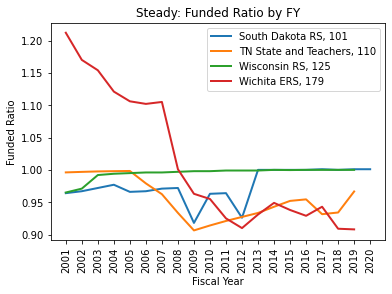

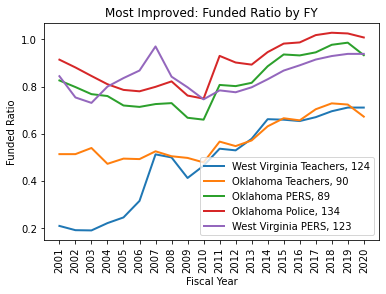

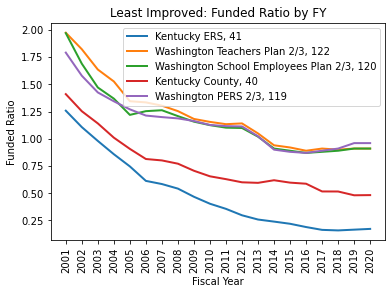

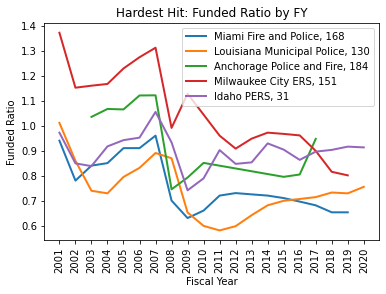

In [22]:
#Generate line plots of funded ratio by fiscal year for each group
for key,value in study_plans_dict.items():
    for plans in value:
        plan_x=plan_test_data_df[plan_test_data_df["ppd_id"]==plans]
        plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
        plan_x_contpaid=plan_x["PercentReqContPaid"]
        plan_x_fy=plan_x["fy"]
        plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
        plt.title(f'{key}: Funded Ratio by FY')
        plt.ylabel("Funded Ratio")
        plt.xlabel("Fiscal Year")
        plt.plot(plan_x_fy,plan_x_fundrat,linewidth="2",label=f'{plan_x_name}, {plans}')
        plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.savefig(f'plot images/all_{key}_fundrat_fy.png')
    plt.show()

Our findings.  Brief intro to how we decided on the questions we chose.

#Question 2A

#Question 2B: Is there a relationship between the percentage of the required funding contribution made by plan sponsors each year and the funded ratio?  Are steady plan sponsors more likely to make their full required contribution?  

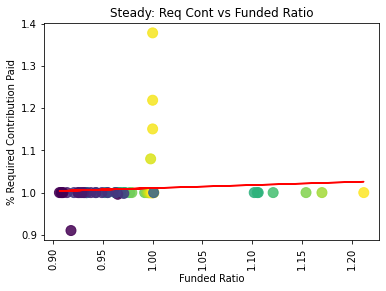

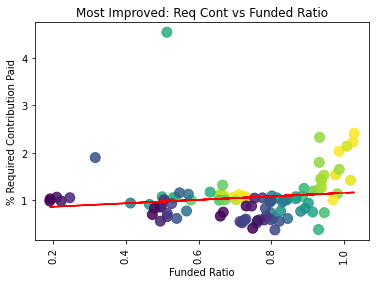

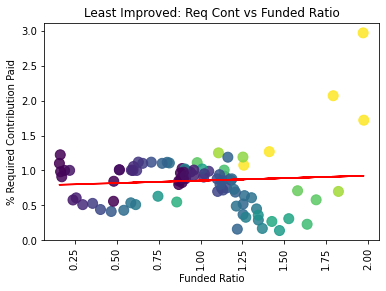

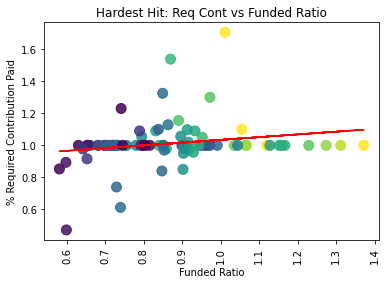

In [23]:
#Plot percent of required contribution paid vs funded ratio for each study group
for key,value in study_plans_dict.items():
    for plans in value:
        plan_x=plan_test_data_df[plan_test_data_df["ppd_id"]==plans]
        plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
        plan_x_contpaid=plan_x["PercentReqContPaid"]
        plan_x_fy=plan_x["fy"]
        plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
        plt.title(f'{key}: Req Cont vs Funded Ratio')
        plt.ylabel("% Required Contribution Paid")
        plt.xlabel("Funded Ratio")
        plt.scatter(plan_x_fundrat,plan_x_contpaid,c=plan_x_fundrat, alpha=.85,s=100)
        plt.xticks(rotation=90)
    #Generate linear regression    
    x_values = plan_test_data_df.loc[plan_test_data_df["ppd_id"].isin(value),"ActFundedRatio_GASB"]
    y_values = plan_test_data_df.loc[plan_test_data_df["ppd_id"].isin(value),"PercentReqContPaid"]
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.plot(x_values,regress_values,"r-")
    plt.savefig(f'plot images/all_{key}_fundrat_contpaid.png')
    plt.show()

Looking at the group plot data, it appears that, as we would expect, all of the Steady Group plans make 100% or more of their required contributions consistently with few outliers, while the others are more volatile.  Somewhat surprisingly, the hardest hit plans also appear to make 100% or greater of their required contribution fairly consistently.

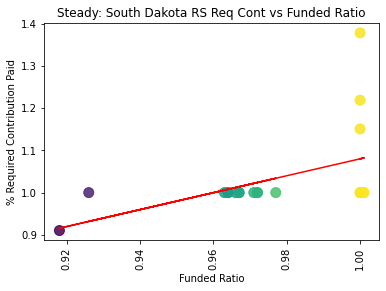

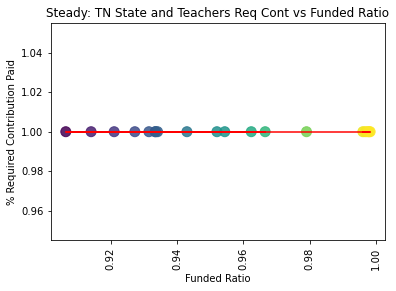

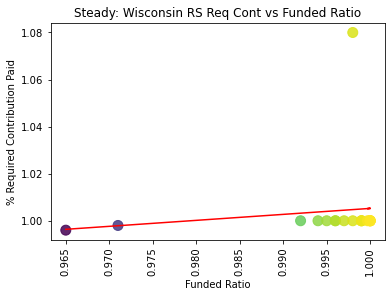

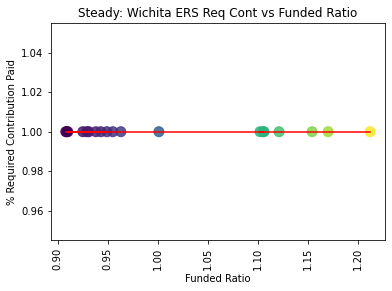

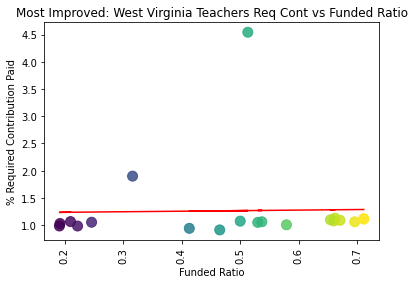

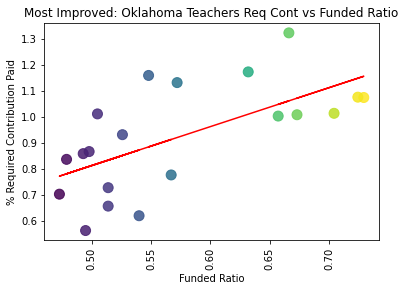

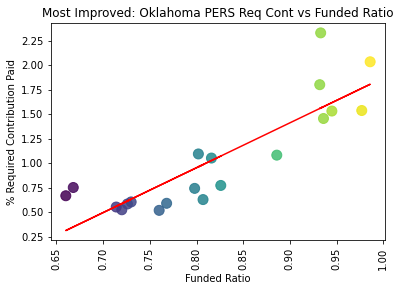

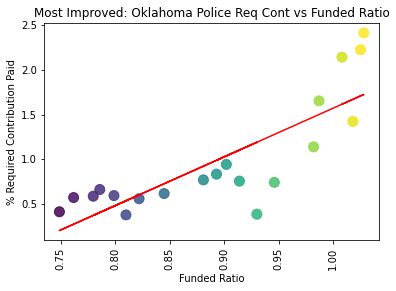

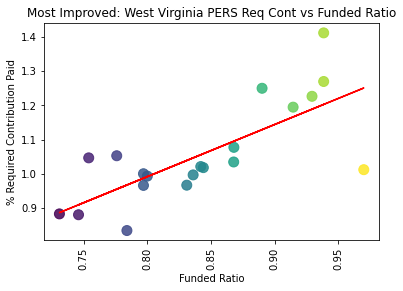

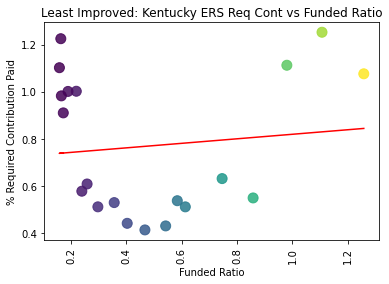

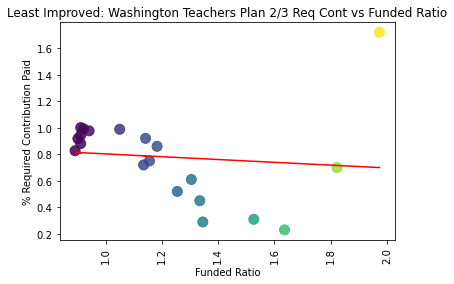

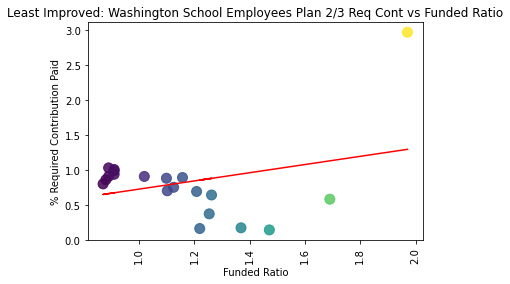

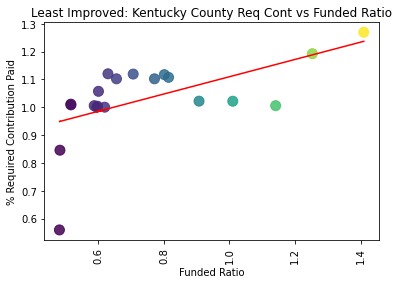

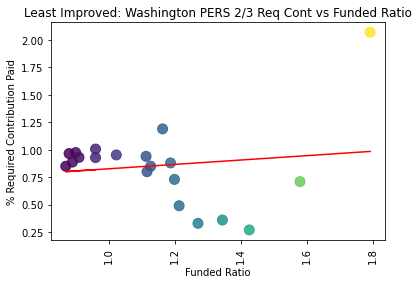

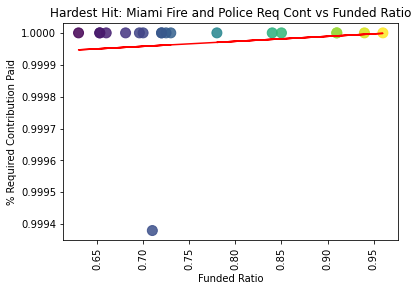

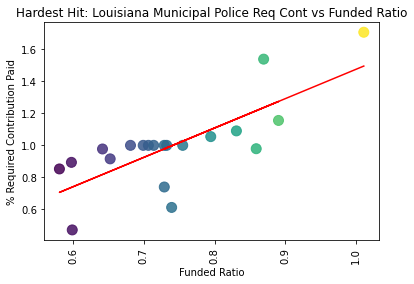

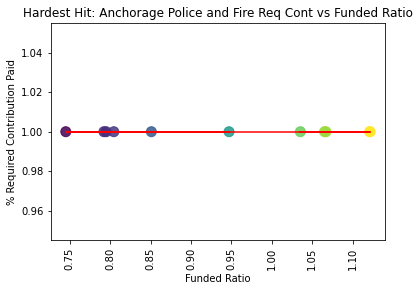

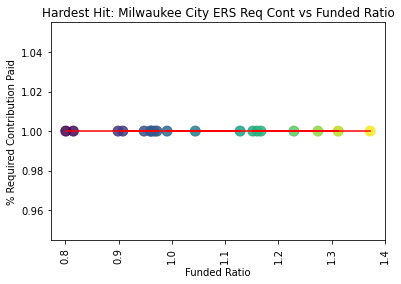

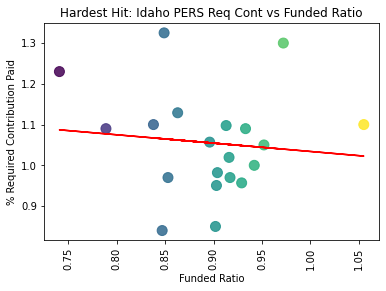

In [24]:
#Plot %required contribution versus funded ratio for individual plans
for key,value in study_plans_dict.items():
    for plans in value:
        plan_x=plan_test_data_df[plan_test_data_df["ppd_id"]==plans]
        plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
        plan_x_contpaid=plan_x["PercentReqContPaid"]
        plan_x_fy=plan_x["fy"]
        plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
        plt.title(f'{key}: {plan_x_name} Req Cont vs Funded Ratio')
        plt.ylabel("% Required Contribution Paid")
        plt.xlabel("Funded Ratio")
        plt.scatter(plan_x_fundrat,plan_x_contpaid,c=plan_x_fundrat, alpha=.85, s=100)
        plt.xticks(rotation=90)
        x_values = plan_test_data_df.loc[plan_test_data_df["ppd_id"]==plans,"ActFundedRatio_GASB"]
        y_values = plan_test_data_df.loc[plan_test_data_df["ppd_id"]==plans,"PercentReqContPaid"]
        (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
        regress_values = x_values * slope + intercept
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        plt.plot(x_values,regress_values,"r-")
        plt.savefig(f'plot images/{key}_{plans}_fundrat_contpaid.png')
        plt.show()

Looking at the indiviudal plan plots for % funding ratio versus funded ratio gives us mor einsight into the more volatile behavior that we saw previously.

#Question 2C

#Question 2D

#Question 2E: How do the total costs and admin fees relate to the funded ratio?  Do the steady plans get a "better deal" by getting charged less as a percentage of their total assets than plans that are more volatile?  In order to normalize large plans against small plans, instead of looking at simply total fees deducted, we first calculated total fees each year as a percentage of the avg total assets.

In [25]:
#generate subset DFs and remove rows with empty asset or fees data
penincomestatement_data_df=penincomestatement_data_full[['ppd_id','fy','expense_AdminExpenses','expense_investments_tot','MktAssets_net','BegMktAssets_net']].dropna()
plan_income_data_df=pd.merge(penincomestatement_data_df,plan_data_df,how="inner",on="ppd_id")
plan_income_data_df['expense_AdminExpenses'] = plan_income_data_df['expense_AdminExpenses'].astype(float)
plan_income_data_df['expense_investments_tot'] = plan_income_data_df['expense_investments_tot'].astype(float)

In [26]:
#merge DFs to generate dataframe with funded ratio and income data
plan_income_funded_data_df=pd.merge(plan_income_data_df,funded_ratio_df,how="inner",left_on=["ppd_id","fy"],right_on=["ppd_id","fy"])
plan_income_funded_data_df['ActFundedRatio_GASB'] = plan_income_funded_data_df['ActFundedRatio_GASB'].astype(float)
plan_income_funded_data_df['PercentReqContPaid'] = plan_income_funded_data_df['PercentReqContPaid'].astype(float)
plan_income_funded_data_df['MktAssets_net'] = plan_income_funded_data_df['MktAssets_net'].astype(float)
plan_income_funded_data_df['BegMktAssets_net'] = plan_income_funded_data_df['BegMktAssets_net'].astype(float)

In [27]:
#Calulate ratio of expenses to assets and add it as an additional column in  the DF
plan_income_funded_data_df['Avg_Assets']=(plan_income_funded_data_df['MktAssets_net']+plan_income_funded_data_df['BegMktAssets_net'])/2
plan_income_funded_data_df['Total_absExpenses']=plan_income_funded_data_df['expense_AdminExpenses'].abs()+plan_income_funded_data_df['expense_investments_tot'].abs()
plan_income_funded_data_df['Exp_Asset_Ratio']=plan_income_funded_data_df['Total_absExpenses']/plan_income_funded_data_df['Avg_Assets']

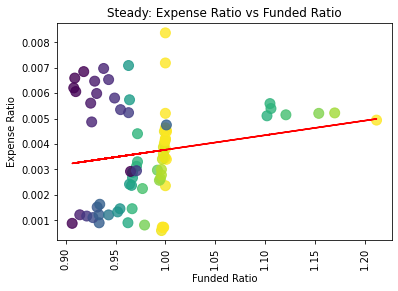

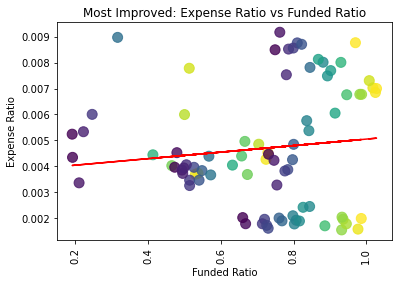

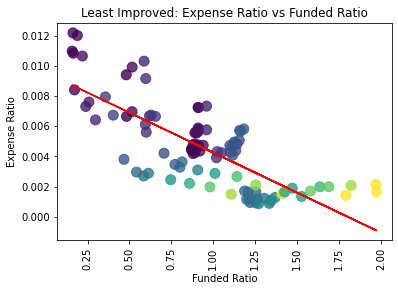

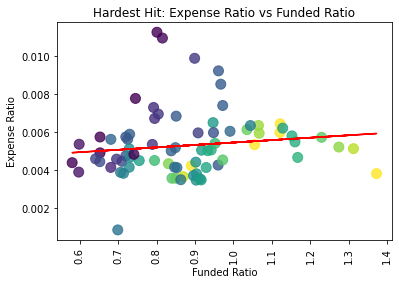

In [28]:
#Plot expense-asset-ratio vs funded ratio for each group
for key,value in study_plans_dict.items():
    for plans in value:
        plan_x=plan_income_funded_data_df[plan_income_funded_data_df["ppd_id"]==plans]
        plan_x_exprat=plan_x["Exp_Asset_Ratio"]
        plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
        plan_x_fy=plan_x["fy"]
        plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
        plt.title(f'{key}: Expense Ratio vs Funded Ratio')
        plt.xlabel("Funded Ratio")
        plt.ylabel("Expense Ratio")
        plt.scatter(plan_x_fundrat,plan_x_exprat,c=plan_x_fundrat,s=100,alpha=.8)
        plt.xticks(rotation=90)
    #Generate linear regression    
    y_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"].isin(value),"Exp_Asset_Ratio"]
    x_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"].isin(value),"ActFundedRatio_GASB"]
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.plot(x_values,regress_values,"r-")
    plt.savefig(f'plot images/all_{key}_exprat_fundrat.png')
    plt.show()

In general, we see that as funding ratio rises, expense ratio generally rises as well, however, the least improved plans and hardest hit plans offer some additional insights.  In both of those groups, we can see that at the point when their funded ratio was the lowest, is often when their plans were being charged the highest fees as a percentage of their total assets.  This may owe to a flat fee structure, or be a sign of mismanagement on the part of the firm that they used.

#Question 2F

#Question 2G